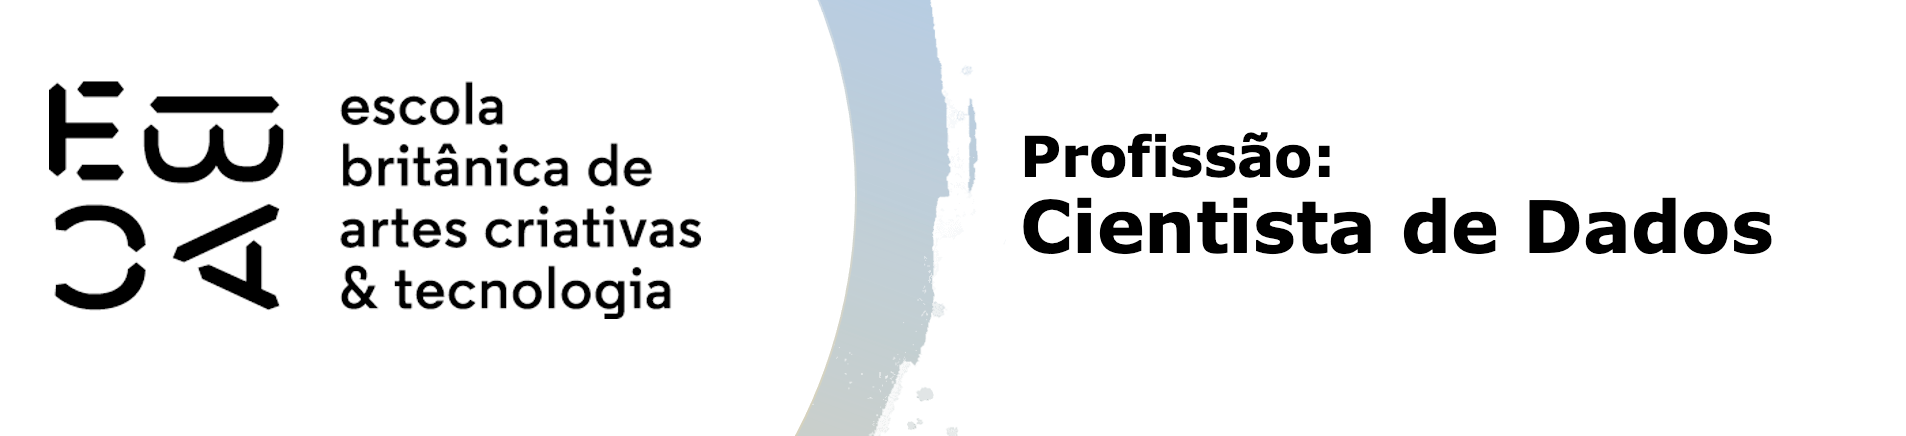

# Tarefa I

Neste projeto, estamos construindo um credit scoring para cartão de crédito, em um desenho amostral com 15 safras, e utilizando 12 meses de performance.

Carregue a base de dados ```credit_scoring.ftr```.

In [6]:
import pandas as pd
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score
import statsmodels.api as sm

df = pd.read_feather('credit_scoring.ftr')
df.head()

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
0,2015-01-01,5733,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False
1,2015-01-01,727,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,False
2,2015-01-01,6374,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,False
3,2015-01-01,9566,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,False
4,2015-01-01,9502,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,False


## Amostragem

Separe os três últimos meses como safras de validação *out of time* (oot).

Variáveis:<br>
Considere que a variável ```data_ref``` não é uma variável explicativa, é somente uma variável indicadora da safra, e não deve ser utilizada na modelagem. A variávei ```index``` é um identificador do cliente, e também não deve ser utilizada como covariável (variável explicativa). As restantes podem ser utilizadas para prever a inadimplência, incluindo a renda.


In [7]:
datas_unicas = sorted(df['data_ref'].unique())
print(datas_unicas[-5:])  


ultimos_tres_meses = datas_unicas[-3:]


df_oot = df[df['data_ref'].isin(ultimos_tres_meses)].copy()
df_modelagem = df[~df['data_ref'].isin(ultimos_tres_meses)].copy()


print("Safras OOT:")
print(df_oot['data_ref'].unique())
print("Tamanho do conjunto OOT:", df_oot.shape)
print("Tamanho do conjunto de modelagem:", df_modelagem.shape)

[Timestamp('2015-11-01 00:00:00'), Timestamp('2015-12-01 00:00:00'), Timestamp('2016-01-01 00:00:00'), Timestamp('2016-02-01 00:00:00'), Timestamp('2016-03-01 00:00:00')]
Safras OOT:
<DatetimeArray>
['2016-01-01 00:00:00', '2016-02-01 00:00:00', '2016-03-01 00:00:00']
Length: 3, dtype: datetime64[ns]
Tamanho do conjunto OOT: (150000, 15)
Tamanho do conjunto de modelagem: (600000, 15)


## Descritiva básica univariada

- Descreva a base quanto ao número de linhas, número de linhas para cada mês em ```data_ref```.
- Faça uma descritiva básica univariada de cada variável. Considere as naturezas diferentes: qualitativas e quantitativas.

In [8]:
print("Número total de linhas:", df.shape[0])


linhas_por_mes = df['data_ref'].value_counts().sort_index()
print("\nNúmero de linhas por mês:")
print(linhas_por_mes)

variaveis_quant = ['idade', 'tempo_emprego', 'qt_pessoas_residencia', 'renda']
df[variaveis_quant].describe()


variaveis_qualitativas = ['sexo', 'posse_de_veiculo', 'posse_de_imovel',
                          'tipo_renda', 'educacao', 'estado_civil',
                          'tipo_residencia', 'mau']

for var in variaveis_qualitativas:
    print(f"\n--- {var} ---")
    print(df[var].value_counts(dropna=False))
    print("Proporção (%)")
    print(df[var].value_counts(normalize=True, dropna=False) * 100)


Número total de linhas: 750000

Número de linhas por mês:
data_ref
2015-01-01    50000
2015-02-01    50000
2015-03-01    50000
2015-04-01    50000
2015-05-01    50000
2015-06-01    50000
2015-07-01    50000
2015-08-01    50000
2015-09-01    50000
2015-10-01    50000
2015-11-01    50000
2015-12-01    50000
2016-01-01    50000
2016-02-01    50000
2016-03-01    50000
Name: count, dtype: int64

--- sexo ---
sexo
F    504580
M    245420
Name: count, dtype: int64
Proporção (%)
sexo
F    67.277333
M    32.722667
Name: proportion, dtype: float64

--- posse_de_veiculo ---
posse_de_veiculo
N    457954
S    292046
Name: count, dtype: int64
Proporção (%)
posse_de_veiculo
N    61.060533
S    38.939467
Name: proportion, dtype: float64

--- posse_de_imovel ---
posse_de_imovel
S    503692
N    246308
Name: count, dtype: int64
Proporção (%)
posse_de_imovel
S    67.158933
N    32.841067
Name: proportion, dtype: float64

--- tipo_renda ---
tipo_renda
Assalariado         385740
Empresário          172712


## Descritiva bivariada

Faça uma análise descritiva bivariada de cada variável


==== SEXO ====
Contagem:
mau    False   True     All
sexo                       
F     463950  40630  504580
M     227407  18013  245420
All   691357  58643  750000

Proporção de inadimplentes por categoria:
sexo
F    8.05%
M    7.34%
Name: True, dtype: object

==== POSSE_DE_VEICULO ====
Contagem:
mau                False   True     All
posse_de_veiculo                       
N                 421872  36082  457954
S                 269485  22561  292046
All               691357  58643  750000

Proporção de inadimplentes por categoria:
posse_de_veiculo
N    7.88%
S    7.73%
Name: True, dtype: object

==== POSSE_DE_IMOVEL ====
Contagem:
mau               False   True     All
posse_de_imovel                       
N                224515  21793  246308
S                466842  36850  503692
All              691357  58643  750000

Proporção de inadimplentes por categoria:
posse_de_imovel
N    8.85%
S    7.32%
Name: True, dtype: object

==== TIPO_RENDA ====
Contagem:
mau                Fa

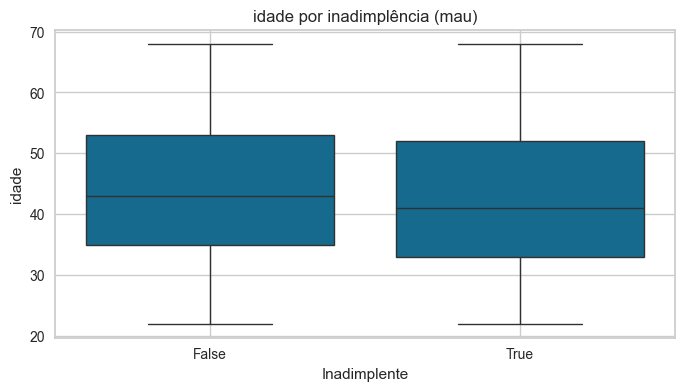


==== TEMPO_EMPREGO ====
          count      mean       std       min       25%       50%        75%  \
mau                                                                            
False  575806.0  8.004300  6.807303  0.117808  3.219178  6.345205  10.556164   
True    48237.0  4.695965  3.913739  0.117808  1.715068  3.854795   6.621918   

             max  
mau               
False  42.906849  
True   42.906849  


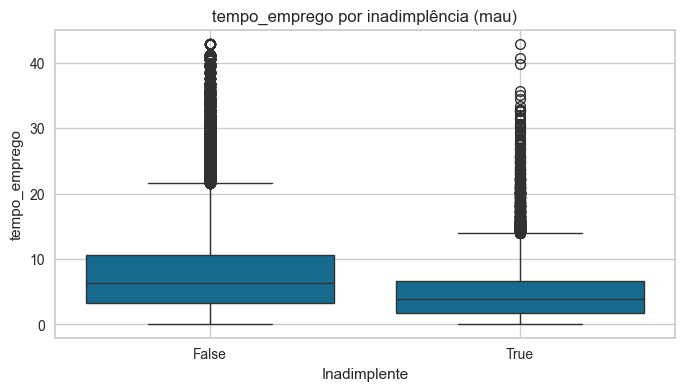


==== QT_PESSOAS_RESIDENCIA ====
          count      mean       std  min  25%  50%  75%   max
mau                                                          
False  691357.0  2.211221  0.901365  1.0  2.0  2.0  3.0  15.0
True    58643.0  2.224272  0.927327  1.0  2.0  2.0  3.0  15.0


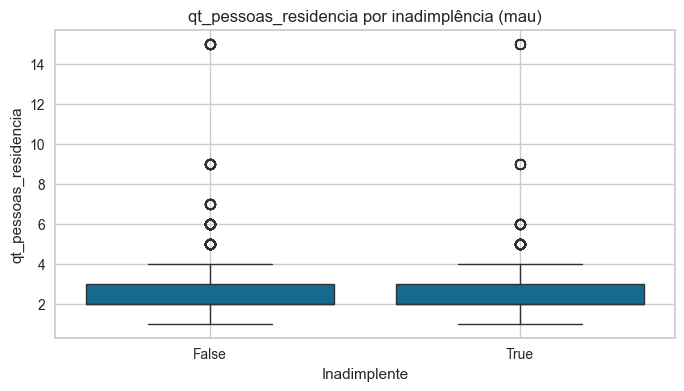


==== RENDA ====
          count          mean           std     min       25%      50%  \
mau                                                                      
False  691357.0  24804.689618  82154.474316  113.36  3896.300  8602.87   
True    58643.0   4774.871007   9612.302738  107.67  1301.785  2507.28   

            75%         max  
mau                          
False  19688.06  4083986.22  
True    5133.16   989799.47  


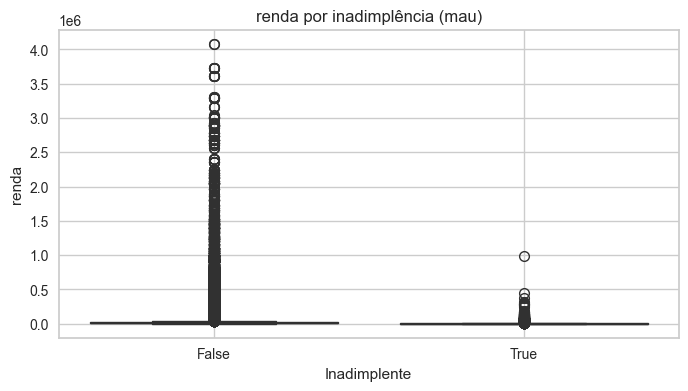

In [9]:
import pandas as pd

variaveis_qualitativas = ['sexo', 'posse_de_veiculo', 'posse_de_imovel',
                          'tipo_renda', 'educacao', 'estado_civil',
                          'tipo_residencia']

for var in variaveis_qualitativas:
    print(f"\n==== {var.upper()} ====")
    tab = pd.crosstab(df[var], df['mau'], margins=True)
    prop = pd.crosstab(df[var], df['mau'], normalize='index') * 100
    print("Contagem:")
    print(tab)
    print("\nProporção de inadimplentes por categoria:")
    print(prop[True].round(2).astype(str) + '%')



import matplotlib.pyplot as plt
import seaborn as sns

variaveis_quant = ['idade', 'tempo_emprego', 'qt_pessoas_residencia', 'renda']

for var in variaveis_quant:
    print(f"\n==== {var.upper()} ====")
    print(df.groupby('mau')[var].describe())

    # Visualização
    plt.figure(figsize=(8, 4))
    sns.boxplot(data=df, x='mau', y=var)
    plt.title(f'{var} por inadimplência (mau)')
    plt.xlabel('Inadimplente')
    plt.ylabel(var)
    plt.grid(True)
    plt.show()


## Desenvolvimento do modelo

Desenvolva um modelo de *credit scoring* através de uma regressão logística.

- Trate valores missings e outliers
- Trate 'zeros estruturais'
- Faça agrupamentos de categorias conforme vimos em aula
- Proponha uma equação preditiva para 'mau'
- Caso hajam categorias não significantes, justifique

In [10]:


df_modelagem_proc = df_modelagem.copy()


missing = df_modelagem_proc.isnull().sum()
print("Valores faltantes:")
print(missing[missing > 0])

df_modelagem_proc['tempo_emprego'] = df_modelagem_proc['tempo_emprego'].fillna(0)
df_modelagem_proc['qt_pessoas_residencia'] = df_modelagem_proc['qt_pessoas_residencia'].fillna(
    df_modelagem_proc['qt_pessoas_residencia'].median()
)


df_modelagem_proc['educacao'] = df_modelagem_proc['educacao'].replace({
    'Fundamental incompleto': 'Fundamental',
    'Superior incompleto': 'Superior',
    'Pós-graduação': 'Superior'
})


df_modelagem_proc['tipo_renda'] = df_modelagem_proc['tipo_renda'].replace({
    'Servidor público': 'Assalariado',
    'Empresário': 'Outros',
    'Pensionista': 'Outros',
    'Bolsista': 'Outros',
    'Outro': 'Outros'
})


df_modelagem_proc['mau'] = df_modelagem_proc['mau'].astype(int)


df_dummies = pd.get_dummies(df_modelagem_proc.drop(columns=['data_ref', 'index']), drop_first=True)


X = df_dummies.drop(columns='mau')
y = df_dummies['mau']


X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)


modelo = LogisticRegression(max_iter=1000)
modelo.fit(X_train, y_train)


y_pred = modelo.predict(X_test)
y_proba = modelo.predict_proba(X_test)[:, 1]


print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred))
print(f"AUC: {roc_auc_score(y_test, y_proba):.4f}")


coef = pd.Series(modelo.coef_[0], index=X.columns)
print("\nCoeficientes da Regressão Logística:")
print(coef.sort_values(ascending=False))


X_sm = sm.add_constant(X_train)


X_sm = X_sm.astype(float)
y_train_sm = y_train.astype(float)

logit = sm.Logit(y_train_sm, X_sm).fit()
print("\nResumo da regressão logística (statsmodels):")
print(logit.summary())


Valores faltantes:
tempo_emprego    100875
dtype: int64

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97    169007
           1       0.00      0.00      0.00     10993

    accuracy                           0.94    180000
   macro avg       0.47      0.50      0.48    180000
weighted avg       0.88      0.94      0.91    180000

AUC: 0.7646

Coeficientes da Regressão Logística:
qtd_filhos                       0.238934
estado_civil_União               0.068335
posse_de_veiculo_S               0.035564
renda                           -0.000102
idade                           -0.002240
educacao_Pós graduação          -0.006475
tipo_residencia_Estúdio         -0.015961
tempo_emprego                   -0.020012
tipo_residencia_Comunitário     -0.056029
tipo_renda_Outros               -0.101832
posse_de_imovel_S               -0.103124
sexo_M                          -0.124300
tipo_residencia_Casa            -0

## Avaliação do modelo

Avalie o poder discriminante do modelo pelo menos avaliando acurácia, KS e Gini.

Avalie estas métricas nas bases de desenvolvimento e *out of time*.

In [11]:

df_modelagem_proc['data_ref'] = df_modelagem['data_ref']


df_modelagem_proc['data_ref'] = pd.to_datetime(df_modelagem_proc['data_ref'])


limite_data = df_modelagem_proc['data_ref'].max() - pd.DateOffset(months=1)


df_dev = df_modelagem_proc[df_modelagem_proc['data_ref'] <= limite_data]
df_oot = df_modelagem_proc[df_modelagem_proc['data_ref'] > limite_data]


def preprocessar(df):
    df = df.copy()
    df['tempo_emprego'] = df['tempo_emprego'].fillna(0)
    df['qt_pessoas_residencia'] = df['qt_pessoas_residencia'].fillna(df['qt_pessoas_residencia'].median())

    df['educacao'] = df['educacao'].replace({
        'Fundamental incompleto': 'Fundamental',
        'Superior incompleto': 'Superior',
        'Pós-graduação': 'Superior'
    })

    df['tipo_renda'] = df['tipo_renda'].replace({
        'Servidor público': 'Assalariado',
        'Empresário': 'Outros',
        'Pensionista': 'Outros',
        'Bolsista': 'Outros',
        'Outro': 'Outros'
    })

    df = df.drop(columns=['data_ref', 'index'])
    df = pd.get_dummies(df, drop_first=True)
    return df

df_dev_proc = preprocessar(df_dev)
df_oot_proc = preprocessar(df_oot)


X_dev = df_dev_proc.drop(columns='mau')
y_dev = df_dev_proc['mau']

X_oot = df_oot_proc.drop(columns='mau')
y_oot = df_oot_proc['mau']



modelo = LogisticRegression(max_iter=1000)
modelo.fit(X_dev, y_dev)


y_dev_pred = modelo.predict(X_dev)
y_dev_proba = modelo.predict_proba(X_dev)[:, 1]

y_oot_pred = modelo.predict(X_oot)
y_oot_proba = modelo.predict_proba(X_oot)[:, 1]



from sklearn.metrics import accuracy_score, roc_auc_score
from scipy.stats import ks_2samp


print(f"Acurácia (DEV): {accuracy_score(y_dev, y_dev_pred):.4f}")
print(f"Acurácia (OOT): {accuracy_score(y_oot, y_oot_pred):.4f}")


auc_dev = roc_auc_score(y_dev, y_dev_proba)
auc_oot = roc_auc_score(y_oot, y_oot_proba)
gini_dev = 2 * auc_dev - 1
gini_oot = 2 * auc_oot - 1

print(f"AUC (DEV): {auc_dev:.4f} | Gini (DEV): {gini_dev:.4f}")
print(f"AUC (OOT): {auc_oot:.4f} | Gini (OOT): {gini_oot:.4f}")


def ks_stat(y_true, y_proba):
    return ks_2samp(y_proba[y_true == 1], y_proba[y_true == 0]).statistic

ks_dev = ks_stat(y_dev, y_dev_proba)
ks_oot = ks_stat(y_oot, y_oot_proba)

print(f"KS (DEV): {ks_dev:.4f}")
print(f"KS (OOT): {ks_oot:.4f}")




Acurácia (DEV): 0.9422
Acurácia (OOT): 0.9029
AUC (DEV): 0.7655 | Gini (DEV): 0.5310
AUC (OOT): 0.7328 | Gini (OOT): 0.4656
KS (DEV): 0.3938
KS (OOT): 0.3460


# a - Criar um pipeline utilizando o sklearn pipeline para o preprocessamento 

## Pré processamento

### Substituição de nulos (nans)

Existe nulos na base? é dado numérico ou categórico? qual o valor de substituição? média? valor mais frequente? etc

In [12]:
df_modelagem.isnull().sum()[df_modelagem.isnull().sum() > 0]


tempo_emprego    100875
dtype: int64

In [13]:
colunas_numericas_com_nulo = ['tempo_emprego', 'qt_pessoas_residencia']
colunas_numericas = ['idade', 'tempo_emprego', 'qt_pessoas_residencia', 'renda', 'qtd_filhos']
colunas_categoricas = ['sexo', 'posse_de_veiculo', 'posse_de_imovel',
                       'tipo_renda', 'educacao', 'estado_civil', 'tipo_residencia']


from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer


num_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),  
    ('scaler', StandardScaler())
])


cat_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  
    ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'))
])


preprocessor = ColumnTransformer(transformers=[
    ('num', num_pipeline, colunas_numericas),
    ('cat', cat_pipeline, colunas_categoricas)
])


from sklearn.linear_model import LogisticRegression

pipeline_modelo = Pipeline(steps=[
    ('preprocessamento', preprocessor),
    ('modelo', LogisticRegression(max_iter=1000))
])

X = df_modelagem.drop(columns=['mau', 'data_ref', 'index'])
y = df_modelagem['mau']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)

pipeline_modelo.fit(X_train, y_train)

y_pred = pipeline_modelo.predict(X_test)
y_proba = pipeline_modelo.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))
print(f"AUC: {roc_auc_score(y_test, y_proba):.4f}")


              precision    recall  f1-score   support

       False       0.94      1.00      0.97    169007
        True       0.00      0.00      0.00     10993

    accuracy                           0.94    180000
   macro avg       0.47      0.50      0.48    180000
weighted avg       0.88      0.94      0.91    180000

AUC: 0.7640


### Criação de dummies

Aplicar o get_dummies() ou onehotencoder() para transformar colunas catégoricas do dataframe em colunas de 0 e 1. 
- sexo
- posse_de_veiculo
- posse_de_imovel
- tipo_renda
- educacao
- estado_civil
- tipo_residencia

In [14]:
variaveis_categoricas = [
    'sexo', 'posse_de_veiculo', 'posse_de_imovel',
    'tipo_renda', 'educacao', 'estado_civil', 'tipo_residencia'
]

variaveis_numericas = [
    'idade', 'tempo_emprego', 'qt_pessoas_residencia', 'qtd_filhos', 'renda'
]

colunas_modelo = variaveis_categoricas + variaveis_numericas

X = df_modelagem[colunas_modelo]
y = df_modelagem['mau']


pipeline_numerico = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])


pipeline_categorico = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'))
])


preprocessador = ColumnTransformer(transformers=[
    ('num', pipeline_numerico, variaveis_numericas),
    ('cat', pipeline_categorico, variaveis_categoricas)
])


pipeline_modelo = Pipeline(steps=[
    ('preprocessamento', preprocessador),
    ('modelo', LogisticRegression(max_iter=1000))
])


X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)

pipeline_modelo.fit(X_train, y_train)


y_pred = pipeline_modelo.predict(X_test)
y_proba = pipeline_modelo.predict_proba(X_test)[:, 1]

print("\n📊 Classification Report:")
print(classification_report(y_test, y_pred))

print(f"🔍 AUC: {roc_auc_score(y_test, y_proba):.4f}")


📊 Classification Report:
              precision    recall  f1-score   support

       False       0.94      1.00      0.97    169007
        True       0.00      0.00      0.00     10993

    accuracy                           0.94    180000
   macro avg       0.47      0.50      0.48    180000
weighted avg       0.88      0.94      0.91    180000

🔍 AUC: 0.7640


### Pipeline 

Crie um pipeline contendo essas funções.

preprocessamento()
- substituicao de nulos
- remoção outliers
- PCA
- Criação de dummy de pelo menos 1 variável (posse_de_veiculo)

In [15]:
def remover_outliers(X):
    if isinstance(X, np.ndarray):
        X = pd.DataFrame(X)
    X_out = X.copy()
    for col in X_out.columns:
        Q1 = X_out[col].quantile(0.25)
        Q3 = X_out[col].quantile(0.75)
        IQR = Q3 - Q1
        lim_inf = Q1 - 1.5 * IQR
        lim_sup = Q3 + 1.5 * IQR
        X_out[col] = np.where((X_out[col] < lim_inf) | (X_out[col] > lim_sup), np.nan, X_out[col])
    return X_out.values


numericas = ['idade', 'tempo_emprego', 'qt_pessoas_residencia']
categoricas = ['posse_de_veiculo']


def preprocessamento(numericas, categoricas):
    transformer = ColumnTransformer(transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler())
        ]), numericas),
        
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(drop='first'))
        ]), categoricas)
    ])
    
    return Pipeline(steps=[
        ('transformer', transformer),
        ('outliers', FunctionTransformer(remover_outliers, validate=False)),
        ('imputer_final', SimpleImputer(strategy='mean')),
        ('pca', PCA(n_components=0.95))  # Mantém 95% da variância
    ])


X = df_modelagem.drop(columns='mau')
y = df_modelagem['mau']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)


pipeline_final = Pipeline(steps=[
    ('preprocessamento', preprocessamento(numericas, categoricas)),
    ('modelo', LogisticRegression(max_iter=1000))
])


pipeline_final.fit(X_train, y_train)


y_pred = pipeline_final.predict(X_test)
y_proba = pipeline_final.predict_proba(X_test)[:, 1]

NameError: name 'FunctionTransformer' is not defined

# b - Pycaret na base de dados 

Utilize o pycaret para pre processar os dados e rodar o modelo **lightgbm**. Faça todos os passos a passos da aula e gere os gráficos finais. E o pipeline de toda a transformação.



In [ ]:
import pandas as pd

df = pd.read_feather('credit_scoring.ftr')
df.head()

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
0,2015-01-01,5733,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False
1,2015-01-01,727,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,False
2,2015-01-01,6374,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,False
3,2015-01-01,9566,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,False
4,2015-01-01,9502,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,False


In [17]:
from pycaret.classification import *
setup(data=df, target='mau')

,Description,Value
0,Session id,3690
1,Target,mau
2,Target type,Binary
3,Original data shape,"(750000, 15)"
4,Transformed data shape,"(750000, 34)"
5,Transformed train set shape,"(525000, 34)"
6,Transformed test set shape,"(225000, 34)"
7,Numeric features,6
8,Date features,1
9,Categorical features,7


In [ ]:
clf_setup = setup(
    data=df,
    target='mau',
    session_id=123,
    train_size=0.8,
    categorical_features=[
        'sexo', 'posse_de_veiculo', 'posse_de_imovel', 'tipo_renda',
        'educacao', 'estado_civil', 'tipo_residencia'
    ],
    numeric_features=['idade', 'tempo_emprego', 'qt_pessoas_residencia', 'qtd_filhos', 'renda'],
    ignore_features=['data_ref', 'index'],
    remove_outliers=True,
    normalize=True,
    transformation=True,
    verbose=True
)


best_model = compare_models()


lightgbm_model = create_model('lightgbm')


tuned_lgbm = tune_model(lightgbm_model)


plot_model(tuned_lgbm, plot='confusion_matrix')
plot_model(tuned_lgbm, plot='auc')
plot_model(tuned_lgbm, plot='feature')


interpret_model(tuned_lgbm)


final_model = finalize_model(tuned_lgbm)


save_model(final_model, 'modelo_lightgbm_pycaret')



,Description,Value
0,Session id,123
1,Target,mau
2,Target type,Binary
3,Original data shape,"(750000, 15)"
4,Transformed data shape,"(720003, 30)"
5,Transformed train set shape,"(570003, 30)"
6,Transformed test set shape,"(150000, 30)"
7,Ignore features,2
8,Numeric features,5
9,Categorical features,7


,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,16:31:12
Status,. . . . . . . . . . . . . . . . . .,Fitting 10 Folds
Estimator,. . . . . . . . . . . . . . . . . .,K Neighbors Classifier


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.9222,0.7815,0.0326,0.5392,0.0615,0.0531,0.1183,9.1630


Processing:   0%|          | 0/65 [00:00<?, ?it/s]